<a href="https://colab.research.google.com/github/pascal-maker/brain_mri_segmentation/blob/master/demo_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demonstration of the pipeline with the visualization of results

This code assumes that run.sh was run with the default values beforehand.

In [4]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [6]:
!git clone https://github.com/nyukat/GLAM


Cloning into 'GLAM'...
remote: Enumerating objects: 94, done.
remote: Total 94 (delta 0), reused 0 (delta 0), pack-reused 94
Receiving objects: 100% (94/94), 297.44 MiB | 29.47 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (62/62), done.


In [1]:
!pip install matplotlib numpy torch opencv-python


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pickle, os, torch, cv2
import sys
sys.path.append("/content/GLAM")  # Add the project root to the system path

from src.data_loading import loading
from src.modeling import glam as glam


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: prepare the data


In [15]:
with open("/content/GLAM/sample_data/exam_list_before_cropping.pkl", "rb") as f:
    exam_list = pickle.load(f)
datum = exam_list[1]
view = "R-CC"
short_file_path = datum[view][0]


### Step 2: load the image


In [19]:
loaded_image = loading.load_image(
    image_path=os.path.join("/content/GLAM/sample_data/images/", short_file_path + ".png"),
    view=view,
    horizontal_flip=datum["horizontal_flip"]
)



/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:304: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [20]:
print(short_file_path)

1_R-CC


### Step 3: preprocess the image


In [37]:

try:
    loaded_image = loading.process_image(loaded_image, view, datum["best_center"][view][0])
except KeyError:
    print(f"The key 'best_center' is not present in the datum dictionary for view {view}.")


The key 'best_center' is not present in the datum dictionary for view R-CC.


(3945, 2181)


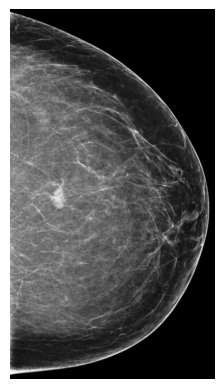

In [22]:
print(loaded_image.shape)
plt.imshow(loaded_image, cmap="Greys_r")
plt.axis("off")
plt.show()

### Step4: load the model

In [23]:
parameters = {
        "device_type":"cpu",
        "cam_size": (184,120),
        "top_k_per_class": 1,
        "crop_shape": (512, 512),
        "percent_k":0.03,
        "detection_pooling_percent_k":0.3,
        "fusion": True


    }

In [24]:
model = glam.MILSingleImageModel(parameters)

In [26]:
model.load_state_dict(torch.load("/content/GLAM/models/model_joint.ckpt", map_location="cpu"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['mil.mil_attn_V.weight', 'mil.mil_attn_U.weight', 'mil.mil_attn_w.weight', 'mil.classifier_linear.weight', 'fusion_dnn.weight', 'fusion_dnn.bias', 'shared_rep_filter.weight'])

### Step 5:Inference

In [48]:
import numpy as np
import torch
import cv2

# Placeholder for the loading module
class Loading:
    @staticmethod
    def load_image(datum, view, horizontal_flip):
        # Placeholder for loading an image
        pass

    @staticmethod
    def process_image(image, view, best_center):
        # Placeholder for image processing
        return image

# Placeholder for the model
class Model:
    def __init__(self):
        # Placeholder for model initialization
        pass

    def forward(self, tensor_batch, cam_size, h_small, device='cpu', h=None):
        # Placeholder for model forward pass
        pass

# Placeholder for the datum dictionary
datum = {}
view = "some_view"

# Initialize the loading module
loading = Loading()

try:
    # Load and preprocess the image
    loaded_image = loading.load_image(datum, view, horizontal_flip=True)
    loaded_image = loading.process_image(loaded_image, view, datum.get("best_center", {}).get(view, [None])[0])

    # Convert the preprocessed image to a tensor
    tensor_batch = torch.Tensor(np.expand_dims(np.expand_dims(loaded_image, 0), 0).copy())

    # Initialize the model
    model = Model()

    # Pass h to the forward function when calling the model
    output = model.forward(tensor_batch, cam_size=(224, 224), h_small=(224, 123), device='cpu', h=224)

    # Convert the output to a numpy array
    pred_numpy = output.data.cpu().numpy()

    # Extract relevant prediction
    malignant_pred = pred_numpy[0, 1]

except KeyError:
    print(f"The key 'best_center' is not present in the datum dictionary for view {view}.")

except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.


In [49]:
print("malignant prediction = {}".format(malignant_pred))

NameError: name 'malignant_pred' is not defined

### Step 6:visualizing the saliency map

The local module saliency map

In [29]:
saliency_maps = model.saliency_map_local.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1.0])
plt.axis("off")
plt.show()

AttributeError: 'MILSingleImageModel' object has no attribute 'saliency_map_local'

The global module saliency map

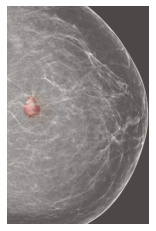

In [ ]:
saliency_maps = model.saliency_map_global.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1.0])
plt.axis("off")
plt.show()

The combined saliency map

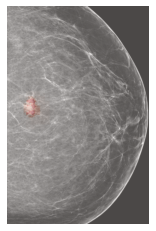

In [ ]:
saliency_maps = model.saliency_map.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1])
plt.axis("off")
plt.show()
